This notebook is a summary on ways of calculating $\dot D$ and its current value, as well as the velocity-velocity correlation functions computed with `mcfit` and otherwise through naive integration.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import zeus21
from scipy.special import spherical_jn
from zeus21.cosmology import growth, dgrowth_dz, Hub

plt.rc('text', usetex=True)
plt.rc('font', family='serif', size=12)

## `Zeus` cosmology and correlation function class setup

In [2]:
UserParams = zeus21.User_Parameters(precisionboost=2)
CosmoParams_input = zeus21.Cosmo_Parameters_Input(kmax_CLASS=1000.)
ClassyCosmo = zeus21.runclass(CosmoParams_input)
CosmoParams = zeus21.Cosmo_Parameters(UserParams, CosmoParams_input, ClassyCosmo) 
CorrFClass = zeus21.Correlations(UserParams, CosmoParams, ClassyCosmo)

## Three ways to calculate $\dot D$

### $\frac{{\rm d}D}{{\rm d}t} = \frac{{\rm d}D}{{\rm d}z} \frac{{\rm d}z}{{\rm d}a} \frac{{\rm d}a}{{\rm d}t} = \frac{{\rm d}D}{{\rm d}z}\left(-\frac{1}{a^2}\right)aH = -\frac{{\rm d}D}{{\rm d}z} \frac{H}{a}$

In [3]:
a_list = np.linspace(0.99, 0.01, 1000)
z_list = 1 / a_list - 1

growth_zeus = growth(CosmoParams, z_list)
dgrowth_zeus = dgrowth_dz(CosmoParams, z_list)

hubble = Hub(CosmoParams, z_list)
dgrowth_dtau = -dgrowth_zeus * hubble / a_list

# At z=0
D_dot_1 = dgrowth_dtau[0]
D_dot_1

np.float64(35.60250249955022)

### $\frac{{\rm d}D}{{\rm d}t} = \frac{{\rm d}D}{{\rm d}a} \frac{{\rm d}a}{{\rm d}t} = fD\cdot aH$, with $f$ approximation given by Lahav+ (1991) (Hamilton Eq.(5))

In [4]:
OmegaM = CosmoParams.OmegaM
OmegaL = CosmoParams.OmegaL
f_0 = OmegaM**(4/7) + (1 + OmegaM / 2) * OmegaL / 70
# D_0=1, a_0=1
D_dot_2 = f_0 * hubble[0]
D_dot_2

np.float64(35.6575903310562)

### Same as above but with $f\approx \Omega_m^{0.545}$ approximation

In [5]:
f_0_alt = OmegaM**0.545
D_dot_3 = f_0_alt * hubble[0]
D_dot_3

np.float64(35.978861088464164)

The three methods give very similar values, but we will use the first one as it doesn't involve any analytical approximations.

In [6]:
D_dot = D_dot_1

## Velocity-velocity correlation functions

These functions have been coded into `Zeus21` and can be simply called as shown below. The computation of $\dot D$ is currently still manually done outside of `Zeus`.

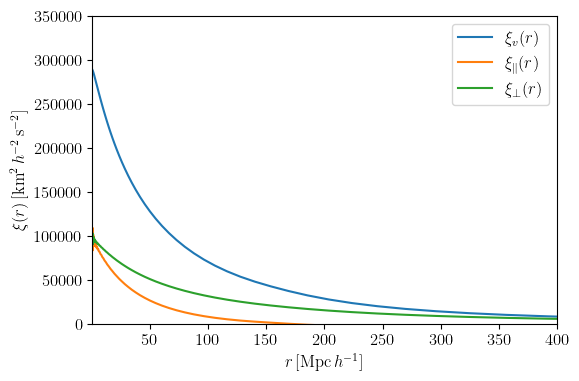

In [7]:
CF_v = CorrFClass.xi_RR_CF_v
CF_perp = CorrFClass.xi_RR_CF_perp
CF_para = CorrFClass.xi_RR_CF_para

r_list = CorrFClass.rlist_CF

plt.figure(figsize=(6, 4))

plt.plot(r_list, D_dot**2 * CF_v[0, 0, :], label=r'$\xi_v(r)$')
plt.plot(r_list, D_dot**2 * CF_para[0, 0, :], label=r'$\xi_{\parallel}(r)$')
plt.plot(r_list, D_dot**2 * CF_perp[0, 0, :], label=r'$\xi_{\perp}(r)$')
plt.xlim(1, 400)
plt.ylim(0, 3.5e5)
plt.xlabel(r'$r\,[\mathrm{Mpc}\,h^{-1}]$')
plt.ylabel(r'$\xi(r)\,[\mathrm{km}^2\,h^{-2}\,\mathrm{s}^{-2}]$')
plt.legend()

By construction of the functions, the correlation functions satisfy $\xi_v=\xi_\parallel+2\xi_\perp$:

In [8]:
CF_v[0, 0, :] == CF_para[0, 0, :] + 2 * CF_perp[0, 0, :]

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True])

Note how the lower $x$ limit is set to greater than 0 in the plot above. This is a temporary solution to the edge artifacts of `fft` occurring at low $r$ values (lots of ringing), which I've so far failed to remedy. The problem seems to affect only those functions involving $j_1$ (namely $\xi_\parallel$ and $\xi_\perp$).

## Agreement with naive integration results

Here we show that we get the same curves from directly computing Eqs. (6-8) of the paper draft.

In [9]:
# Explicitly defining k array here because these functions apparently require high resolution
k = np.linspace(0.001, 10, 50000)
pk = [ClassyCosmo.pk(ki, z=0) for ki in k]

def integrand_para(r):
    return pk * (spherical_jn(0, k*r) - (2/(k*r)) * spherical_jn(1, k*r))
def integrand_perp(r):
    return pk * spherical_jn(1, k*r) / (k*r)
def integrand_v(r):
    return pk * spherical_jn(0, k*r)

def xi_para(r):
    integrand = integrand_para(r)
    return D_dot**2 / (2 * np.pi**2) * np.trapezoid(integrand, k)
def xi_perp(r):
    integrand = integrand_perp(r)
    return D_dot**2 / (2 * np.pi**2) * np.trapezoid(integrand, k)
def xi_v(r):
    integrand = integrand_v(r)
    return D_dot**2 / (2 * np.pi**2) * np.trapezoid(integrand, k)

r_list = CorrFClass.rlist_CF
xi_para = [xi_para(r) for r in r_list]
xi_perp = [xi_perp(r) for r in r_list]
xi_v = [xi_v(r) for r in r_list]

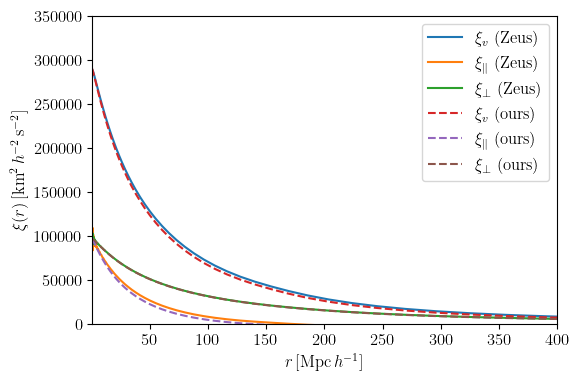

In [13]:
fig, ax = plt.subplots(figsize=(6, 4))

ax.plot(r_list, D_dot**2 * CF_v[0, 0, :], label=r'$\xi_v$ (Zeus)')
ax.plot(r_list, D_dot**2 * CF_para[0, 0, :], label=r'$\xi_{\parallel}$ (Zeus)')
ax.plot(r_list, D_dot**2 * CF_perp[0, 0, :], label=r'$\xi_{\perp}$ (Zeus)')

ax.plot(r_list, np.asarray(xi_v), label=r'$\xi_v$ (ours)', ls='--')
ax.plot(r_list, np.asarray(xi_para), label=r'$\xi_\parallel$ (ours)', ls='--')
ax.plot(r_list, np.asarray(xi_perp), label=r'$\xi_\perp$ (ours)', ls='--')

ax.set_xlim(1, 400)
ax.set_ylim(0, 3.5e5)
ax.set_xlabel(r'$r\,[\mathrm{Mpc}\,h^{-1}]$')
ax.set_ylabel(r'$\xi(r)\,[\mathrm{km}^2\,h^{-2}\,\mathrm{s}^{-2}]$')
ax.legend()

## To do

- Fix `fft` ringing at low $r$ values
- Code $\dot D$ into `Zeus` as well
- Check out the built-in velocity power spectrum functionality in `zeus21/cosmology.py`
- Move on to computing the PDF